# Set up Notebook

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Applied Deep Learning/vehicle-recognition/data/'

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from PIL import ImageFile, Image
import cv2

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Exploration

In [ ]:
vehicles = ['cars/', 'motos/', 'trucks/']

path_train = path + 'train/'
path_test = path + 'test/'
path_val = path + 'val/'

In [ ]:
for vehicle in vehicles:
    path_vehic = path_val + vehicle
    nb_imgs = len(os.listdir(path_vehic))
    print(f'There are {nb_imgs} images of {vehicle.split("/")[0]} in the train set.')


There are 105 images of cars in the train set.
There are 105 images of motos in the train set.
There are 103 images of trucks in the train set.


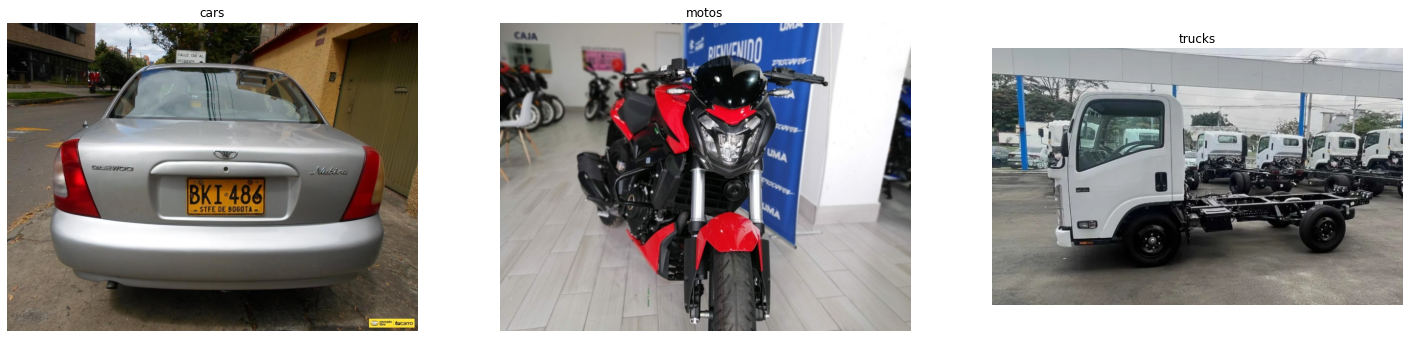

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(25, 10))

path_train_motos = path_train + 'motos/'
motos_train = os.listdir(path_train_motos)

path_train_cars = path_train + 'cars/'
cars_train = os.listdir(path_train_motos)

path_train_trucks = path_train + 'trucks/'
trucks_train = os.listdir(path_train_motos)

list_vehic = [motos_train, cars_train, trucks_train]

for i, vehicle in enumerate(vehicles):

    path_img = path_train + vehicle + list_vehic[i][0]
    img_vehic = Image.open(path_img)
    img_vehic = np.array(img_vehic)
    
    axs[i].imshow(img_vehic)
    axs[i].set_title(vehicle.split('/')[0])
    axs[i].axis('off')

fig.show()


# Load test / train / val sets

In [ ]:
img_height = 224
img_width = 224

data_gen = ImageDataGenerator(featurewise_center=True)
data_gen.mean = [123.68, 116.779, 103.939]

train_generator = data_gen.flow_from_directory(
    path_train,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

val_generator = data_gen.flow_from_directory(
    path_val,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

test_generator = data_gen.flow_from_directory(
    path_test,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2515 images belonging to 3 classes.
Found 313 images belonging to 3 classes.
Found 318 images belonging to 3 classes.


In [ ]:
classes_dict = val_generator.class_indices
classes_dict

{'cars': 0, 'motos': 1, 'trucks': 2}

In [ ]:
val_to_class = {classes_dict[key] : key for key in classes_dict.keys()}

# Models

## VGG-16

In [ ]:
def build_model():

    model_vgg16 = VGG16(include_top=False,
                    weights='imagenet')

    x = model_vgg16.output

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=model_vgg16.input, outputs=predictions)

    for layer in model_vgg16.layers:
        layer.trainable = False

    return model

model_1 = build_model()

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
path_models = path + 'models/'

In [ ]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1, min_delta=1e-4)
checkpoint = ModelCheckpoint(path_models + 'vgg16-brand-recognition.hdf5', monitor='loss', verbose=1, mode='auto', period=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4)
history = model_1.fit(train_generator, epochs=15, batch_size=32, validation_data=val_generator, callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/15
79/79 [==============================] - ETA: 0s - loss: 0.4515 - accuracy: 0.9419
Epoch 1: loss improved from inf to 0.45155, saving model to /content/drive/MyDrive/Applied Deep Learning/vehicle-recognition/data/models/vgg16-brand-recognition.hdf5
79/79 [==============================] - 335s 4s/step - loss: 0.4515 - accuracy: 0.9419 - val_loss: 0.3358 - val_accuracy: 0.9297 - lr: 0.0010
Epoch 2/15
79/79 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.9777
Epoch 2: loss improved from 0.45155 to 0.09415, saving model to /content/drive/MyDrive/Applied Deep Learning/vehicle-recognition/data/models/vgg16-brand-recognition.hdf5
79/79 [==============================] - 54s 689ms/step - loss: 0.0941 - accuracy: 0.9777 - val_loss: 0.2816 - val_accuracy: 0.9393 - lr: 0.0010
Epoch 3/15
79/79 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.9781
Epoch 3: loss improved from 0.09415 to 0.08254, saving model to /content/drive/MyDrive/Applied

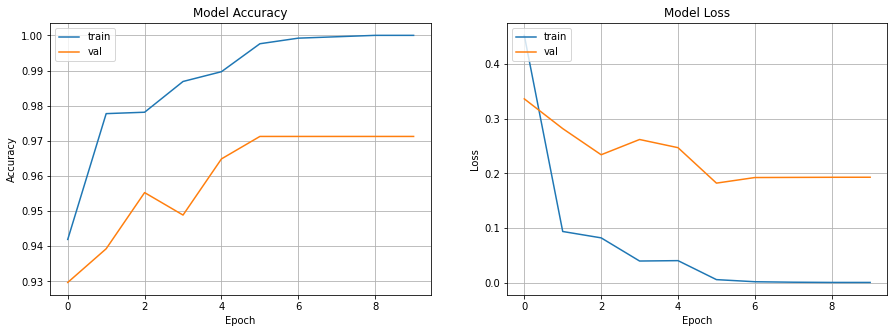

In [ ]:
def plot_history(history):

    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

    # train and val accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    axs[0].grid(True)

    # train and val loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    axs[1].grid(True)
    
    fig.show()

plot_history(history)

Save the model

In [ ]:
path_models = path + 'models/'

model_1.save(path_models + 'pre_vgg_16.h5')

### Evaluate the model on the test set

Load the model

In [ ]:
path_models = path + 'models/'
model_1 = load_model(path_models + 'pre_vgg_16.h5')

Evaluate the model on the whole test set

In [ ]:
model_1.evaluate(test_generator, steps=len(test_generator))

10/10 [==============================] - 85s 9s/step - loss: 0.1255 - accuracy: 0.9811


[0.12548856437206268, 0.9811320900917053]

In [ ]:
y_true = test_generator.classes
y_predicted = model_1.predict(test_generator).argmax(axis=1)

We check the accuracy of the model

In [ ]:
print(f'Accuracy: {(y_true == y_predicted).sum() / len(y_true):.4f}')

Accuracy: 0.9811


In [ ]:
matrix = confusion_matrix(y_true,
                          y_predicted,
                          labels=[0,1,2])

matrix

array([[103,   0,   4],
       [  0, 105,   2],
       [  0,   0, 104]])

See images for which it did not work

In [ ]:
paths_miss_cl = np.array(test_generator.filepaths)[y_true != y_predicted]
true_miss_cl = y_true[y_true != y_predicted]
pred_miss_cl = y_predicted[y_true != y_predicted]

In [ ]:
def predict_img(path_img, model):
    
    img_test = load_img(path_img, target_size=(img_height, img_width))
    input_arr = img_to_array(img_test)
    input_arr = np.array([input_arr])
    input_arr -= [123.68, 116.779, 103.939]
    predictions = model.predict(input_arr).argmax()
    
    return img_test, predictions


In [ ]:
nb_miss = (y_true != y_predicted).sum()

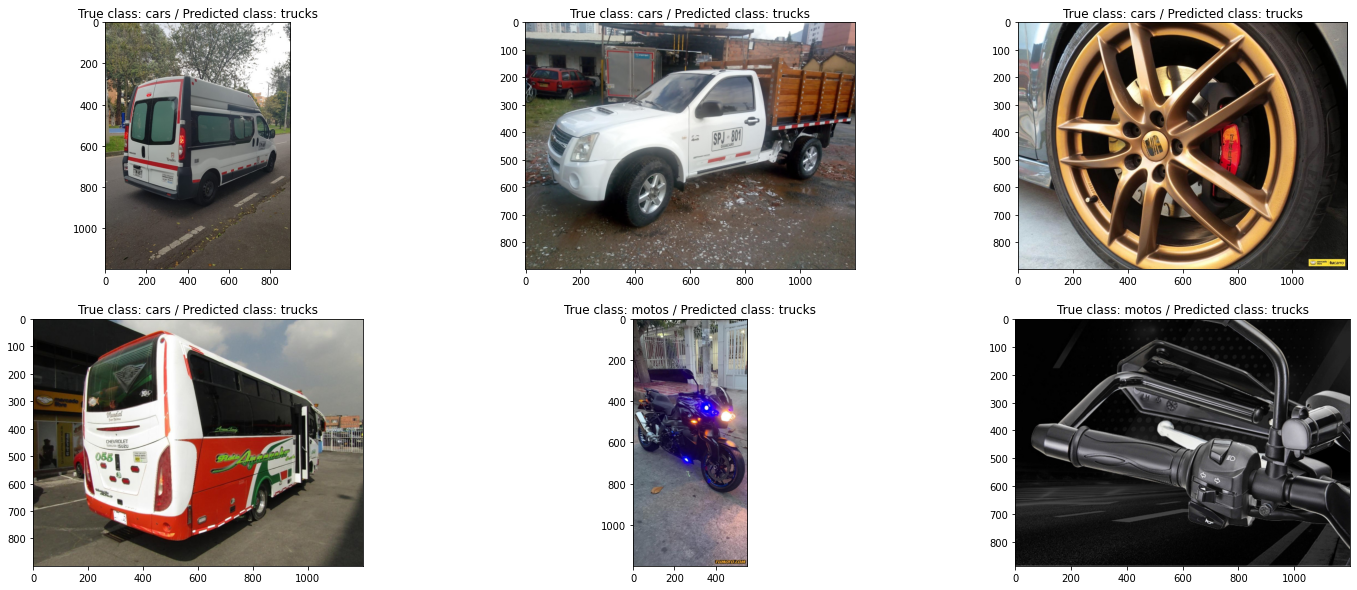

In [ ]:
fig, axs = plt.subplots(nrows=nb_miss//3, ncols=3, figsize=(25, 10))

for idx, path_miss in enumerate(paths_miss_cl):
    i = idx // 3
    j = idx % 3
    img = load_img(path_miss_cl)
    axs[i,j].imshow(img)
    axs[i,j].set_title(f'True class: {val_to_class[true_miss_cl[idx]]} / Predicted class: {val_to_class[pred_miss_cl[idx]]}')

fig.show()


## YOLO

In [ ]:
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image

In [ ]:
with open('/content/drive/MyDrive/yolo/coco.names', 'r') as f:
    classes = f.read().splitlines()

net = cv2.dnn.readNetFromDarknet('/content/drive/MyDrive/yolo/yolov4.cfg', '/content/drive/MyDrive/yolo/yolov4 .weights')
 
model = cv2.dnn_DetectionModel(net)
model.setInputParams(scale=1 / 255, size=(416, 416), swapRB=True)

In [ ]:
def predict_yolo(img_path):
    
    img = cv2.imread(img_path)

    classIds, scores, boxes = model.detect(img, confThreshold=0.6, nmsThreshold=0.4)
    
    for (classId, score, box) in zip(classIds, scores, boxes):
        cv2.rectangle(img, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]),
                    color=(0, 255, 0), thickness=2)
    
        text = '%s: %.2f' % (classes[classId], score)
        cv2.putText(img, text, (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    color=(0, 255, 0), thickness=2)

    return classes[classId], img


Evaluate YOLO on the classification task for the test set

In [ ]:
path_test_motos = path_test + 'motos/'
path_test_cars = path_test + 'cars/'
path_test_trucks = path_test + 'trucks/'

Motos

In [ ]:
acc_moto = 0
miss_paths_motos = []
exceptions_paths_motos = []

for img_path in os.listdir(path_test_motos):
    try:
        if predict_yolo(path_test_motos + img_path)[0] == 'motorbike':
            acc_moto += 1
        else:
            miss_paths_motos.append(path_test_motos + img_path)
    except:
        exceptions_paths_motos.append(path_test_motos + img_path)

print(f'The accuracy for the motos was: {acc_moto / len(os.listdir(path_test_motos))}')

The accuracy for the motos was: 0.9065420560747663


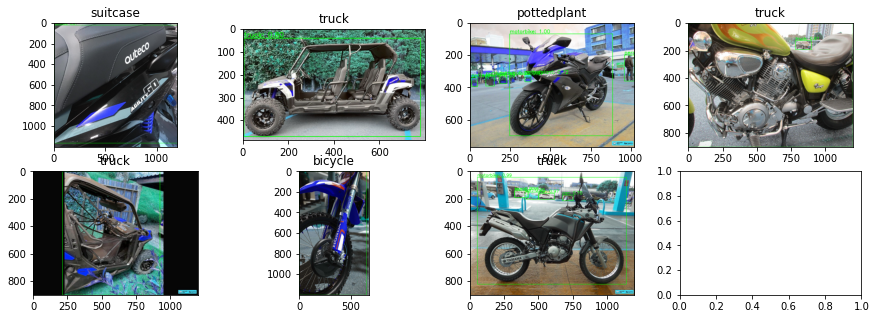

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 5))

for idx, path in enumerate(miss_paths_motos):
    i = idx // 4
    j = idx % 4
    prediction = predict_yolo(path)
    axs[i, j].imshow(prediction[1])
    axs[i, j].set_title(prediction[0])

Cars

In [ ]:
acc_car = 0
miss_paths_cars = []
exceptions_paths_cars = []

for img_path in os.listdir(path_test_cars):
    
    try:
        if predict_yolo(path_test_cars + img_path)[0] == 'car':
            acc_car += 1
        else:
            miss_paths_cars.append(path_test_cars + img_path)
    except:
        exceptions_paths_cars.append(path_test_cars + img_path)

print(f'The accuracy for the cars was: {acc_car / len(os.listdir(path_test_cars))}')

The accuracy for the cars was: 0.6635514018691588


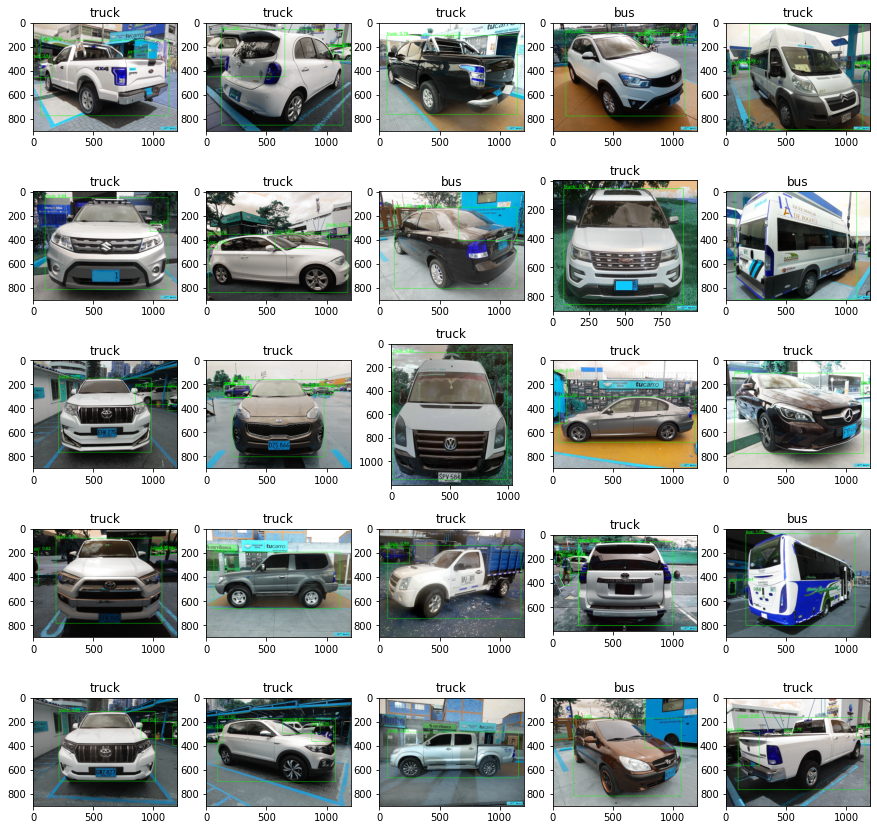

In [ ]:
fig, axs = plt.subplots(ncols=5, nrows=5, figsize=(15, 15))

for idx, path in enumerate(miss_paths_cars[:25]):
    i = idx // 5
    j = idx % 5
    prediction = predict_yolo(path)
    axs[i, j].imshow(prediction[1])
    axs[i, j].set_title(prediction[0])

Trucks

In [ ]:
acc_truck = 0
miss_paths_trucks = []
exceptions_paths_trucks = []

for img_path in os.listdir(path_test_trucks):
    
    try:
        if predict_yolo(path_test_trucks + img_path)[0] == 'truck':
            acc_truck += 1
        else:
            miss_paths_trucks.append(path_test_trucks + img_path)
    except:
        exceptions_paths_trucks.append(path_test_trucks + img_path)

print(f'The accuracy for the trucks was: {acc_truck / len(os.listdir(path_test_trucks))}')

The accuracy for the trucks was: 0.8365384615384616


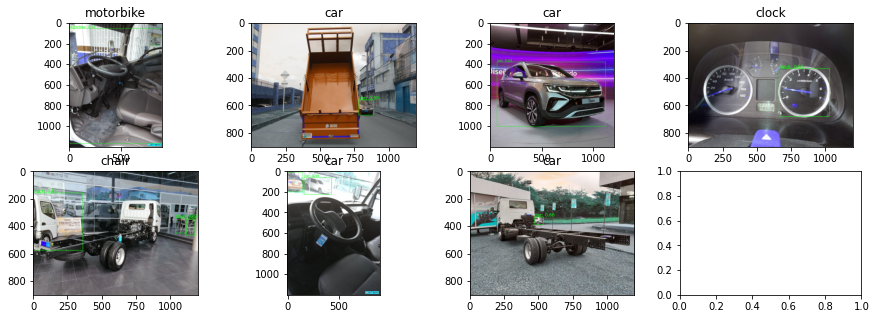

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 5))

for idx, path in enumerate(miss_paths_trucks):
    i = idx // 4
    j = idx % 4
    prediction = predict_yolo(path)
    axs[i, j].imshow(prediction[1])
    axs[i, j].set_title(prediction[0])